In [1]:
from quaternions import *
from networks import *
from sim_helpers import *
from liegroups.numpy import SO3
import torch
from convex_layers import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

In [247]:
path = 'saved_data/synthetic/synthetic_wahba_experiment_12-11-2019-18-48-56.pt'
checkpoint = torch.load(path)
args = checkpoint['args']
A_net = ANet(num_pts=args.matches_per_sample, bidirectional=False).double()
model = QuatNet(A_net=A_net)
print('Loading data...')
model.load_state_dict(checkpoint['model_rep'], strict=False)
print('Done')

Loading data...
Done


In [248]:
train_data, test_data = create_experimental_data(1, 100, args.matches_per_sample, sigma=args.sim_sigma)

In [249]:
def l2_diff(a, b):
    return (a - b).norm(dim=1)
def acos_diff(a, b):
    return (180./3.1415)*torch.acos((a*b).sum(dim=1, keepdim=True)).squeeze()

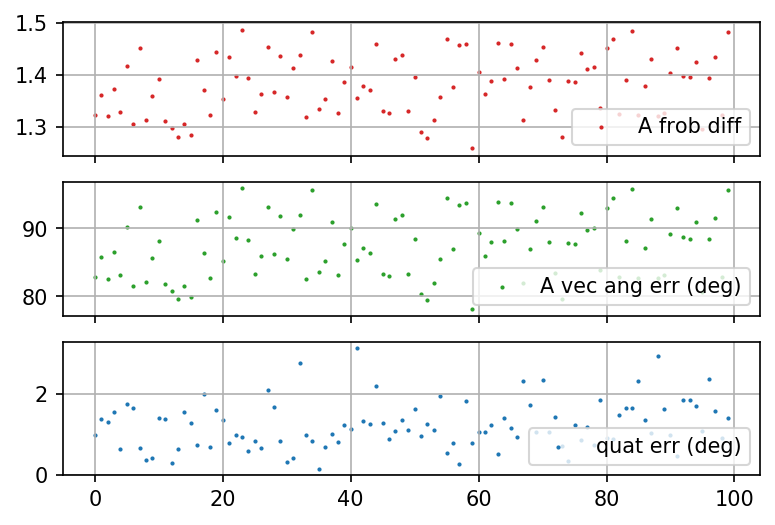

In [250]:
def _scatter(ax, x, y, title, color='tab:red'):
    ax.scatter(x, y, color=color, s=1, label=title)
    ax.grid()
    ax.legend(loc='lower right')
    return

model.eval()
i = torch.arange(0,test_data.x.shape[0])
with torch.no_grad():
    A_pred = model.A_net.forward(test_data.x[i])
    q_est = model.forward(test_data.x[i]).squeeze()
    
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row')
_scatter(ax[0], i, l2_diff(A_pred, convert_A_to_Avec(test_data.A_prior[i])).numpy(), 'A frob diff', color='tab:red')
_scatter(ax[1], i, acos_diff(A_pred, convert_A_to_Avec(test_data.A_prior[i])).numpy(), 'A vec ang err (deg)',color='tab:green')
_scatter(ax[2], i, quat_angle_diff(q_est, test_data.q[i], reduce=False).numpy(), 'quat err (deg)', color='tab:blue')
plt.show()

In [161]:
el, ev = np.linalg.eig(convert_Avec_to_A(A_pred[0]).numpy())
print(el)
#print(ev)
#print(q_est[0])


[-0.80654999  0.83659013  0.37279853  0.49997301]


In [162]:
A = test_data.A_prior[0].clone()
A = A/A.norm()
el, ev = np.linalg.eig(A.numpy())
print(el)
#print(ev)

[6.15285600e-13 5.94580375e-01 5.66807463e-01 5.70266146e-01]


In [8]:
matches = 36
sigma = 1e-10
#sigma_vec = sigma*np.random.randn(matches)
sigma_vec = sigma*np.ones(matches)

#sigma_vec[:int(matches/2)] *= np.random.randn(int(matches/2)) #Artificially scale half the noise

C, x_1, x_2 = gen_sim_data_grid(matches, sigma_vec, torch_vars=False, shuffle_points=False)
print(x_1)
A = build_A(x_1, x_2, sigma_2=sigma_vec**2)
A = A/np.linalg.norm(A)
el, ev = np.linalg.eig(A)
print(el)
print(ev)
print(np.linalg.matrix_rank(A))

[[-0.27376951 -0.94766368 -0.16426747]
 [-0.61387465 -0.53202469 -0.58318749]
 [-0.69068838 -0.23022946 -0.68552459]
 [-0.54945022  0.64935026 -0.5257839 ]
 [ 0.70603423  0.55581418  0.43884653]
 [-0.74788875 -0.30233801 -0.59097728]
 [ 0.67704538  0.45864364  0.57554806]
 [ 0.272092    0.93720578  0.21820005]
 [-0.32252112 -0.92456053 -0.20289888]
 [ 0.36679999  0.90734736  0.20537415]
 [-0.75083901  0.08730686 -0.65468946]
 [-0.33508743 -0.91590565 -0.22098245]
 [-0.55713207  0.67442303 -0.48451773]
 [-0.70146379  0.23382126 -0.67325787]
 [-0.63969571 -0.54492598 -0.54207478]
 [-0.48142933 -0.80238221 -0.35271602]
 [ 0.52896808 -0.69172749  0.4916359 ]
 [-0.65207476 -0.50716926 -0.56354046]
 [ 0.09603523  0.99236406  0.07740035]
 [-0.60627328 -0.64808523 -0.46088855]
 [-0.72730557 -0.11730735 -0.67621417]
 [ 0.45009527 -0.82912287  0.3316165 ]
 [ 0.6814431  -0.6536291   0.32924808]
 [ 0.63771899 -0.46766059  0.61205233]
 [ 0.75437962  0.29251455  0.587662  ]
 [-0.43711344 -0.85341196

In [92]:
matches = 16
C = SO3.exp(np.random.randn(3)).as_matrix()
#v = normalized(np.random.randn(1, 3))
#x_1 = np.concatenate((v, v))
x_1 = normalized(np.random.randn(matches, 3))
x_2 = C.dot(x_1.T).T 
A = build_A(x_1, x_2, sigma_2=np.ones(matches))
A = A / np.linalg.norm(A)

print(A)
el, ev = np.linalg.eig(A)
print(el)
#print(ev)
print(np.linalg.det(A))
print(np.linalg.matrix_rank(A))

# B = 4*np.eye(4) + 2*Omega_l(pure_quat(x_2[0])).dot(
#             Omega_r(pure_quat(x_1[0]))) + 2*Omega_l(pure_quat(x_2[1])).dot(
#             Omega_r(pure_quat(x_1[1])))
# B = B / np.linalg.norm(B)
# print(B)
# print(np.linalg.eig(B))


[[ 6.25161850e-01  1.73726252e-04 -9.73207795e-03  7.03499710e-02]
 [ 1.73726252e-04  2.97097683e-01 -2.72019998e-02  1.96583693e-01]
 [-9.73207795e-03 -2.72019998e-02  6.32341277e-01  6.92308914e-02]
 [ 7.03499710e-02  1.96583693e-01  6.92308914e-02  1.50354203e-01]]
[0.         0.42447614 0.63837725 0.64210162]
9.006943421033043e-19
3


In [280]:
matches = 100
C, x_1, x_2 = gen_sim_data(matches, 1e-1*np.ones(matches), torch_vars=True, shuffle_points=True)
x = torch.empty(1, 2, matches, 3, dtype=torch.double)
x[0,0,:,:] = x_1
x[0,1,:,:] = x_2
q_est = model.forward(x).squeeze()
q_gt = rotmat_to_quat(C, ordering='xyzw')
print(quat_angle_diff(q_est, q_gt))

C_horn = solve_horn(x_1.numpy(), x_2.numpy())
print(quat_angle_diff(rotmat_to_quat(torch.from_numpy(C_horn), ordering='xyzw'), q_gt))

tensor(2.8169, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(2.2020, dtype=torch.float64)


In [275]:
convert_Avec_to_A(torch.arange(10))

tensor([[0, 1, 2, 3],
        [1, 4, 5, 6],
        [2, 5, 7, 8],
        [3, 6, 8, 9]])